In [1]:
import numpy as np
import tensorflow as tf
import os
import cv2
import time
from tftools import network as nw
import collections


import tqdm

In [2]:
class MovingImagesToModel(nw.Network):
    def __init__(self):
        self.left_img = tf.placeholder(tf.float32, shape=[None, 224, 224, 3])
        self.right_img = tf.placeholder(tf.float32, shape=[None, 224, 224, 3])
        self.left_img_next = tf.placeholder(tf.float32, shape=[None, 224, 224, 3])
        self.right_img_next = tf.placeholder(tf.float32, shape=[None, 224, 224, 3])
        self.img = tf.concat(values=[self.left_img, self.left_img_next, 
                                     self.right_img, self.right_img_next], axis=3)
        self.layers = dict({'img':self.img})
        self.trainable = True
        self.setup()        
        
    def setup(self):
        (self.feed('img')
             .conv(7, 7, 128, 2, 2, name='conv1_7x7_s2', group=4)
             .conv(5, 5, 128, 1, 1, name='conv2', group=4)
             .conv(5, 5, 128, 1, 1, name='conv3', group=4)            
             .spatial_softmax(name='ss')
             .fc(96, name='fc6_a', trainable=False)
             .fc(24, name='fc8_a', trainable=False)
             .fc(12, relu=False, name='out', trainable=False))
        
        (self.feed('out')
            .softmax(name='softmax'))

        

In [3]:
net = MovingImagesToModel()

In [4]:
from tftools import data
import sys
import os
episode_model_save_location = '/data/robotics/pick_episodes/models'
episode_data_save_location = '/data/robotics/pick_episodes/data'
pyrobo_path = '/home/karthik/code/pyrobo/'
sys.path.append(os.path.join(pyrobo_path, 'network_models'))

import multicam_net
import trainer

In [5]:
def load_all_training_data(train_data_location):
    train_files = [os.path.join(train_data_location, f) for f in os.listdir(train_data_location)
                   if f.endswith('.tfrecords')]
    img_cnt = 0
    for train_fl in train_files:
        img_cnt += data.TFDataReader(train_fl).count()
    train_inp = np.zeros([2, img_cnt, 224, 224, 3], dtype=np.uint8)
    train_labels = np.zeros([img_cnt, ], dtype=np.int32)
    train_states = np.zeros([img_cnt, 6], dtype=np.float32)
    end_states = np.zeros([img_cnt, ], dtype=np.int32)
    idx = 0
    for train_fl in train_files:
        reader = data.TFDataReader(train_fl)
        fds = reader.readall((["left_image", data.IMG_TYP],
                              ["right_image", data.IMG_TYP],
                              ['motor', data.INT_TYP],
                              ['direction', data.INT_TYP],
                              ['motor_state', data.FLT_TYP]))
        for fd in fds:
            train_inp[0, idx, ...] = multicam_net.resize_to_model(fd['left_image'])
            train_inp[1, idx, ...] = multicam_net.resize_to_model(fd['right_image'])
            motor = int(fd['motor'][0])
            direction = int(fd['direction'][0])
            train_states[idx, :] = np.array(fd['motor_state'])
            label = trainer.motor_2_label(motor, direction)

            train_labels[idx] = label
            idx += 1
        end_states[idx-1] = 1

    return ((train_inp, train_labels, train_states, end_states), img_cnt)



In [6]:
((train_inp, train_labels, train_states, end_states), img_cnt) = load_all_training_data(episode_data_save_location)

In [7]:
sess = tf.Session()

In [8]:
labels_pl = tf.placeholder(shape=(None,), dtype=tf.int32)
loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(logits=net.layers['out'], labels=labels_pl))
optimizer = tf.train.AdamOptimizer(0.0001)
train = optimizer.minimize(loss)
sess.run(tf.global_variables_initializer())



In [11]:
net.load('/data/robotics/pick_episodes/models/export_smallnw.npy', sess, True)

In [14]:
last_100 = collections.deque(100*[100], 100)

tr = tqdm.tnrange(1000)
for step in tr:
#     idxes = np.random.randint(0, img_cnt - 1, size=16)
    idxes = np.random.choice(np.where(end_states==0)[0], size=(16))
    left_im = train_inp[0, idxes, ...]
    right_im = train_inp[1, idxes, ...]
    left_im_next = train_inp[0, idxes+1, ...]
    right_im_next = train_inp[1, idxes+1, ...]
    labels_x = train_labels[idxes]
    states = train_states[idxes, ...]
    batch_data = {labels_pl: labels_x,
                net.left_img: left_im,
                net.left_img_next : left_im_next,
                net.right_img_next : right_im_next,
                net.right_img: right_im}
    [_, lv] = sess.run([train, loss], batch_data)
    last_100.append(lv)
    tr.set_postfix(loss=np.mean(last_100))
 

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt

In [20]:
net.layers['conv3'].get_shape()

TensorShape([Dimension(None), Dimension(112), Dimension(112), Dimension(128)])

In [23]:
idx = np.random.randint(0, img_cnt - 1, size=1)[0]

In [30]:
idxes = np.array([idx])
train_labels[idxes]
left_im = train_inp[0, idxes, ...]
right_im = train_inp[1, idxes, ...]
left_im_next = train_inp[0, idxes+1, ...]
right_im_next = train_inp[1, idxes+1, ...]

conv3 = sess.run(net.layers['conv3'], 
        {       net.left_img: left_im,
                net.left_img_next : left_im_next,
                net.right_img_next : right_im_next,
                net.right_img: right_im})

In [ ]:
cy = np.zeros((128,128), dtype=np.float)
for i in range(128)
    cc = conv3[0,:,:,i]
    cc = cc.astype(np.float)
    cx = np.exp(cc)
    cx/=cx.sum()
    cy+=cx
plt.imshow(cy, cmap=plt.get_cmap("gray"))

(112, 112)


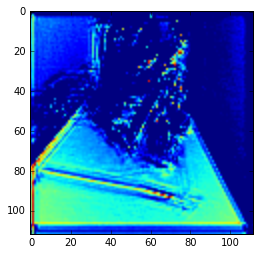

In [48]:
from matplotlib

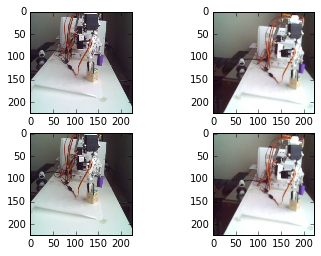

In [27]:
fig = plt.figure()
a=fig.add_subplot(2,2,1)
plt.imshow(train_inp[0, idx, ...])
a = fig.add_subplot(2,2,2)
plt.imshow(train_inp[1, idx, ...])
a=fig.add_subplot(2,2,3)
plt.imshow(train_inp[0, 1+idx, ...])
a = fig.add_subplot(2,2,4)
plt.imshow(train_inp[1, 1+idx, ...])


In [ ]:
idxes = np.random.choice(np.where(end_states==0)[0], size=(16))
left_im = train_inp[0, idxes, ...]
right_im = train_inp[1, idxes, ...]
left_im_next = train_inp[0, idxes+1, ...]
right_im_next = train_inp[1, idxes+1, ...]


In [ ]:
idxes, idxes+1

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
right_im.shape

In [ ]:
plt.imshow(left_im[3, ...])

In [ ]:
plt.imshow(left_im_next[3, ...])

In [16]:
    s = []
    for layer in net.layers:
        s+=([ (layer, v) for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) if v.name.startswith(layer) ])

    outdict = {}
    for layer, var in s:
        varname = var.name.replace(':0', '')
        varvalue = var.eval(sess)
        if '/' in varname and len(varname) == 2:
            (base,det) = varname.split('/')
            indict = outdict.get(base, {})
            indict[det] = varvalue
            outdict[base] = indict
        else:
            outdict[varname] = varvalue


conv3/weights
conv3/biases
conv3/weights/Adam
conv3/weights/Adam_1
conv3/biases/Adam
conv3/biases/Adam_1
conv2/weights
conv2/biases
conv2/weights/Adam
conv2/weights/Adam_1
conv2/biases/Adam
conv2/biases/Adam_1
fc6_a/weights
fc6_a/biases
conv1_7x7_s2/weights
conv1_7x7_s2/biases
conv1_7x7_s2/weights/Adam
conv1_7x7_s2/weights/Adam_1
conv1_7x7_s2/biases/Adam
conv1_7x7_s2/biases/Adam_1
fc8_a/weights
fc8_a/biases
out/weights
out/biases


In [17]:
np.save('/data/robotics/pick_episodes/models/export_multiim_pred.npy', outdict)

In [9]:
saver = tf.train.Saver()

In [ ]:
saver.restore(sess, '/data/robotics/pick_episodes/models/alternate_model_100k')

In [ ]:
saver.save(sess, '/data/robotics/pick_episodes/models/alternate_model_90k_test')

In [10]:
saver.restore(sess, '/data/robotics/pick_episodes/models/alternate_model_90k_test')

NotFoundError: Key beta1_power not found in checkpoint
	 [[Node: save/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]
	 [[Node: save/RestoreV2_8/_45 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_53_save/RestoreV2_8", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op u'save/RestoreV2', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-18da33d742f9>", line 1, in <module>
    saver = tf.train.Saver()
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/saver.py", line 1040, in __init__
    self.build()
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/saver.py", line 1070, in build
    restore_sequentially=self._restore_sequentially)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/saver.py", line 675, in build
    restore_sequentially, reshape)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/saver.py", line 402, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/saver.py", line 242, in restore_op
    [spec.tensor.dtype])[0])
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_io_ops.py", line 668, in restore_v2
    dtypes=dtypes, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Key beta1_power not found in checkpoint
	 [[Node: save/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]
	 [[Node: save/RestoreV2_8/_45 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_53_save/RestoreV2_8", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


## Approach 2:  Simultaneous learning of Value networks and autoencoders

1. Build a value network for predicting the cost
2. The cost is the number of steps until successful episode end.
3. Value network provides a representation of the state
4. To make the first part of the value network robust to noise. Use the output of the value network for other tasks as well